In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/ml_experiments/PDEFIND')
from PDE_FIND import *
import scipy.io as sio

In [2]:
data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/rd.mat")

Text(0, 0.5, 'y')

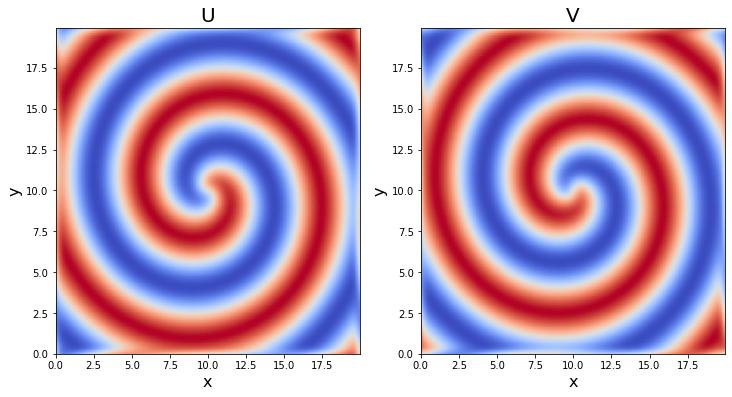

In [3]:
t = data['t'].T[:,0]
x = data['x'][0,:]
y = data['y'][0,:]
U = data['u']
V = data['v']

n = len(x) # also the length of y
steps = len(t)
dx = x[2]-x[1]
dy = y[2]-y[1]
dt = t[2]-t[1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
xx, yy = np.meshgrid(np.arange(n)*dx,np.arange(n)*dy)
ax1.pcolor(xx,yy,U[:,:,10],cmap='coolwarm')
ax1.set_title('U', fontsize = 20)
ax1.set_xlabel('x', fontsize = 16)
ax1.set_ylabel('y', fontsize = 16)
ax2.pcolor(xx,yy,V[:,:,10],cmap='coolwarm')
ax2.set_title('V', fontsize = 20)
ax2.set_xlabel('x', fontsize = 16)
ax2.set_ylabel('y', fontsize = 16)

In [4]:
# Sample a collection of data points.  See figure 1 panel 2a.
np.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 30
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    y = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,6*t+10]
        count = count + 1

In [5]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
vt = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))
vx = np.zeros((num_points,1))
vy = np.zeros((num_points,1))
vxx = np.zeros((num_points,1))
vxy = np.zeros((num_points,1))
vyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():

    [x,y,t] = points[p]

    # value of function
    u[p] = U[x,y,t]
    v[p] = V[x,y,t]

    # time derivatives
    ut[p] = PolyDiffPoint(U[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    vt[p] = PolyDiffPoint(V[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]

    # spatial derivatives
    ux_diff = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(U[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    vx_diff = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    vy_diff = PolyDiffPoint(V[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    vx_diff_yp = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    vx_diff_ym = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)

    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]

    vx[p] = vx_diff[0]
    vy[p] = vy_diff[0]
    vxx[p] = vx_diff[1]
    vxy[p] = (vx_diff_yp[0]-vx_diff_ym[0])/(2*dy)
    vyy[p] = vy_diff[1]

In [6]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([u,v])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u','v'])
['1'] + description[1:]

['1',
 'u_{x}',
 'u_{y}',
 'u_{xx}',
 'u_{xy}',
 'u_{yy}',
 'v_{x}',
 'v_{y}',
 'v_{xx}',
 'v_{xy}',
 'v_{yy}',
 'v',
 'u',
 'v^2',
 'uv',
 'u^2',
 'v^3',
 'uv^2',
 'u^2v',
 'u^3',
 'vu_{x}',
 'uu_{x}',
 'v^2u_{x}',
 'uvu_{x}',
 'u^2u_{x}',
 'v^3u_{x}',
 'uv^2u_{x}',
 'u^2vu_{x}',
 'u^3u_{x}',
 'vu_{y}',
 'uu_{y}',
 'v^2u_{y}',
 'uvu_{y}',
 'u^2u_{y}',
 'v^3u_{y}',
 'uv^2u_{y}',
 'u^2vu_{y}',
 'u^3u_{y}',
 'vu_{xx}',
 'uu_{xx}',
 'v^2u_{xx}',
 'uvu_{xx}',
 'u^2u_{xx}',
 'v^3u_{xx}',
 'uv^2u_{xx}',
 'u^2vu_{xx}',
 'u^3u_{xx}',
 'vu_{xy}',
 'uu_{xy}',
 'v^2u_{xy}',
 'uvu_{xy}',
 'u^2u_{xy}',
 'v^3u_{xy}',
 'uv^2u_{xy}',
 'u^2vu_{xy}',
 'u^3u_{xy}',
 'vu_{yy}',
 'uu_{yy}',
 'v^2u_{yy}',
 'uvu_{yy}',
 'u^2u_{yy}',
 'v^3u_{yy}',
 'uv^2u_{yy}',
 'u^2vu_{yy}',
 'u^3u_{yy}',
 'vv_{x}',
 'uv_{x}',
 'v^2v_{x}',
 'uvv_{x}',
 'u^2v_{x}',
 'v^3v_{x}',
 'uv^2v_{x}',
 'u^2vv_{x}',
 'u^3v_{x}',
 'vv_{y}',
 'uv_{y}',
 'v^2v_{y}',
 'uvv_{y}',
 'u^2v_{y}',
 'v^3v_{y}',
 'uv^2v_{y}',
 'u^2vv_{y}',
 'u^3v_

In [7]:
c = TrainSTRidge(X,ut,10**-5,1)
print_pde(c, description)

u_t = (0.100014 +0.000000i)u_{xx}
    + (0.100023 +0.000000i)u_{yy}
    + (1.000026 +0.000000i)u
    + (0.999995 +0.000000i)v^3
    + (-1.000008 +0.000000i)uv^2
    + (0.999995 +0.000000i)u^2v
    + (-1.000008 +0.000000i)u^3
   


In [8]:
c = TrainSTRidge(X,vt,10**-5,1)
print_pde(c, description, ut = 'v_t')

v_t = (0.100020 +0.000000i)v_{xx}
    + (0.100012 +0.000000i)v_{yy}
    + (1.000014 +0.000000i)v
    + (-0.999997 +0.000000i)v^3
    + (-0.999995 +0.000000i)uv^2
    + (-0.999998 +0.000000i)u^2v
    + (-0.999996 +0.000000i)u^3
   
